<a href="https://colab.research.google.com/github/hafezgh/Hate-Speech-Detection-in-Social-Media/blob/main/BERT_Multilingual_Extension/BERT_extensions_multilingual_subtask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [72]:
!pip install transformers==3.0.0
!pip install emoji
import gc
import os
import emoji as emoji
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoModel
from transformers import BertModel, BertTokenizer
import copy
from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings('ignore')

In [2]:
!git clone https://github.com/suman101112/hasoc-fire-2020

Cloning into 'hasoc-fire-2020'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 35 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), done.


# Read and prepare data


In [3]:
data_en = pd.read_excel("/content/hasoc-fire-2020/2020/hasoc_2020_en_train_new_a.xlsx")
data_en_test = pd.read_csv("/content/hasoc-fire-2020/2020/english_test_1509.csv")
data_en['language'] = 0
data_en_test['language'] = 0
data_de = pd.read_excel("/content/hasoc-fire-2020/2020/hasoc_2020_de_train_new_a.xlsx")
data_de_test = pd.read_csv("/content/hasoc-fire-2020/2020/german_test_1509.csv")
data_de['language'] = 1
data_de_test['language'] = 1
data_hi = pd.read_excel("/content/hasoc-fire-2020/2020/hasoc_2020_hi_train_a.xlsx")
data_hi_test = pd.read_csv("/content/hasoc-fire-2020/2020/hindi_test_1509.csv")
data_hi['language'] = 2
data_hi_test['language'] = 2

data = copy.deepcopy(data_en)
data = data.append(data_de, ignore_index=True)
data = data.append(data_hi, ignore_index=True)
data_test = copy.deepcopy(data_en_test)
data_test = data_test.append(data_de_test, ignore_index=True)
data_test = data_test.append(data_hi_test, ignore_index=True)

labels = data[['task1', 'task2', 'language']]
le = LabelEncoder()
labels['task1'] = le.fit_transform(labels['task1'])
le = LabelEncoder()
labels['task2'] = le.fit_transform(labels['task2'])

labels_test = data_test[['task1', 'task2', 'language']]
le = LabelEncoder()
labels_test['task1'] = le.fit_transform(labels_test['task1'])
le = LabelEncoder()
labels_test['task2'] = le.fit_transform(labels_test['task2'])

data.head()

,tweet_id,text,task1,task2,ID,language
0,1.123757e+18,"hate wen females hit ah nigga with tht bro 😂😂,...",HOF,PRFN,hasoc_2020_en_2574,0
1,1.123733e+18,RT @airjunebug: When you're from the Bay but y...,HOF,PRFN,hasoc_2020_en_3627,0
2,1.123734e+18,RT @DonaldJTrumpJr: Dear Democrats: The Americ...,NOT,NONE,hasoc_2020_en_3108,0
3,1.126951e+18,RT @SheLoveTimothy: He ain’t on drugs he just ...,HOF,PRFN,hasoc_2020_en_3986,0
4,1.126864e+18,RT @TavianJordan: Summer ‘19 I’m coming for yo...,NOT,NONE,hasoc_2020_en_5152,0


In [33]:
labels

,task1,task2,language
0,0,3,0
1,0,3,0
2,1,1,0
3,0,3,0
4,1,1,0
...,...,...,...
9039,1,1,2
9040,1,1,2
9041,0,0,2
9042,0,2,2


In [4]:
data = data.drop(columns=['tweet_id','task1', 'task2','language','ID'])

In [5]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, train_size=0.85, shuffle=True, random_state=2045)

In [6]:
train_set = X_train['text'].to_list()
train_labels1 = y_train['task1'].to_list()
train_labels2 = y_train['task2'].to_list()
train_langs = y_train['language'].to_list()

val_set = X_val['text'].to_list()
val_labels1 = y_val['task1'].to_list()
val_labels2 = y_val['task2'].to_list()
val_langs = y_val['language'].to_list()

test_set = data_test['text'].to_list()
test_labels1 = labels_test['task1'].to_list()
test_labels2 = labels_test['task2'].to_list()
test_langs = labels_test['language'].to_list()

# Utility functions

In [7]:

def pre_process_dataset(values):
    new_values = list()
    # Emoticons
    emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']

    for value in values:
        # Remove dots
        text = value.replace(".", "").lower()
        text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
        users = re.findall("[@]\w+", text)
        for user in users:
            text = text.replace(user, "<user>")
        urls = re.findall(r'(https?://[^\s]+)', text)
        if len(urls) != 0:
            for url in urls:
                text = text.replace(url, "<url >")
        for emo in text:
            if emo in emoji.UNICODE_EMOJI:
                text = text.replace(emo, "<emoticon >")
        for emo in emoticons:
            text = text.replace(emo, "<emoticon >")
        numbers = re.findall('[0-9]+', text)
        for number in numbers:
            text = text.replace(number, "<number >")
        text = text.replace('#', "<hashtag >")
        text = re.sub(r"([?.!,¿])", r" ", text)
        text = "".join(l for l in text if l not in string.punctuation)
        text = re.sub(r'[" "]+', " ", text)
        new_values.append(text)
    return new_values


def data_process(data, labels):
    input_ids = []
    attention_masks = []
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
    for sentence in data:
        bert_inp = bert_tokenizer.__call__(sentence, max_length=64,
                                           padding='max_length', pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)

        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])
    #del bert_tokenizer
    #gc.collect()
    #torch.cuda.empty_cache()
    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    return input_ids, attention_masks, labels



# Model

In [8]:
class BERT_Arch(nn.Module):

    def __init__(self, bert, n_classes, mode='cnn'):
        super(BERT_Arch, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.n_classes = n_classes
        self.mode = mode

        if mode == 'cnn':
            # CNN
            self.conv = nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 768), padding='valid')
            self.relu = nn.ReLU()
            # change the kernel size either to (3,1), e.g. 1D max pooling
            # or remove it altogether
            self.pool = nn.MaxPool2d(kernel_size=(3, 1), stride=1)
            self.dropout = nn.Dropout(0.1)
            # be careful here, this needs to be changed according to your max pooling
            # without pooling: 443, with 3x1 pooling: 416
            # Size after conv = BERT max length - 3 + 1
            # Size after pool = Size after conv - 3 + 1
            # (BERT max length - 3 + 1) - 3 + 1 == BERT max length - 4
            # (kernel_size * (BERT max length - 4), num. classes)

            # IN THIS CASE MAX LENGTH IS SET TO 64
            # FC
            self.fc = nn.Linear(13 * (64 - 4), self.n_classes).to(device)
            self.flat = nn.Flatten()
            
        elif mode == 'rnn':
            ### RNN
            self.lstm = nn.LSTM(768, 256, batch_first=True, bidirectional=True)
            ## FC
            self.fc = nn.Linear(256*2, self.n_classes)
        elif mode == 'shallow_fc':
            self.fc = nn.Linear(768, self.n_classes)
        elif mode == 'deep_fc':
            self.leaky_relu = nn.LeakyReLU(0.01)
            self.fc1 = nn.Linear(768, 768)
            self.dropout = nn.Dropout(0.1)
            self.fc2 = nn.Linear(768, 768)
            self.dropout = nn.Dropout(0.1)
            self.fc3 = nn.Linear(768, self.n_classes)
        else:
            raise NotImplementedError("Unsupported extension!")

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        sequence_output, _, all_layers = self.bert(sent_id, attention_mask=mask, output_hidden_states=True)
        if self.mode == 'cnn':
            x = torch.transpose(torch.cat(tuple([t.unsqueeze(0) for t in all_layers]), 0), 0, 1)
            x = self.pool(self.dropout(self.relu(self.conv(self.dropout(x)))))
            x = self.fc(self.dropout(self.flat(self.dropout(x))))
        elif self.mode == 'rnn':
            lstm_output, (h,c) = self.lstm(sequence_output)
            hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
            x  = self.fc(hidden.view(-1,256*2))
        elif self.mode == 'shallow_fc':
            x = self.fc(sequence_output[:,0,:])
        elif self.mode == 'deep_fc':
            x = self.fc1(sequence_output[:,0,:])
            x = self.leaky_relu(x)
            x = self.fc2(x)
            x = self.leaky_relu(x)
            x = self.fc3(x)
        else:
            raise NotImplementedError("Unsupported extension!")
        gc.collect()
        torch.cuda.empty_cache()
        del all_layers
        c = self.softmax(x)
        return c


# Train

In [9]:

# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    total = len(train_dataloader)
    for i, batch in enumerate(train_dataloader):

        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>'  *(filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        #sent_id = torch.tensor(sent_id).to(device).long()
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss += float(loss.item())

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        #preds = preds.detach().cpu().numpy()

        # append the model predictions
        #total_preds.append(preds)
        total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / (len(train_dataloader)*batch_size)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss and predictions
    return avg_loss, total_preds


# function for evaluating the model
def evaluate():
    print("\n\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    total = len(val_dataloader)
    for i, batch in enumerate(val_dataloader):
        
        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss += float(loss.item())
            #preds = preds.detach().cpu().numpy()

            #total_preds.append(preds)
            total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()

    # compute the validation loss of the epoch
    avg_loss = total_loss / (len(val_dataloader)*batch_size)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


In [58]:
### Extension mode
MODE = 'rnn'

In [59]:
pre_pro_train_data = pre_process_dataset(train_set)
pre_pro_val_data = pre_process_dataset(val_set)
pre_pro_test_data = pre_process_dataset(test_set)

train_input_ids, train_attention_masks, train_labels = data_process(pre_pro_train_data,train_labels1)
val_input_ids, val_attention_masks, val_labels = data_process(pre_pro_val_data,val_labels1)
test_input_ids, test_attention_masks, test_labels = data_process(pre_pro_test_data,test_labels1)


In [60]:
# Specify the GPU
# Setting up the device for GPU usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

train_count = len(train_labels)
test_count = len(test_labels)
val_count = len(val_labels)

# ~~~~~~~~~~~~~~~~~~~~~ Import BERT Model and BERT Tokenizer ~~~~~~~~~~~~~~~~~~~~~#
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-multilingual-cased')
# bert = AutoModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


cuda


In [66]:

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Tokenization ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for train set
train_seq = torch.tensor(train_input_ids.tolist())
train_mask = torch.tensor(train_attention_masks.tolist())
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(val_input_ids.tolist())
val_mask = torch.tensor(val_attention_masks.tolist())
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(test_input_ids.tolist())
test_mask = torch.tensor(test_attention_masks.tolist())
test_y = torch.tensor(test_labels.tolist())
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Create DataLoaders ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Freeze BERT Parameters ~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert, n_classes=2, mode=MODE)
# push the model to GPU
model = model.to(device)

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

#from sklearn.utils.class_weight import compute_class_weight

# compute the class weights
#class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

#print(class_wts)

# convert class weights to tensor
#weights = torch.tensor(class_wts, dtype=torch.float)
#weights = weights.to(device)

# loss function
#cross_entropy = nn.NLLLoss(weight=weights)
cross_entropy = nn.NLLLoss()

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
#train_losses = []
#valid_losses = []

#if os.path.isfile("/content/drive/MyDrive/saved_weights.pth") == False:
#if os.path.isfile("saved_weights.pth") == False:
    # number of training epochs
epochs = 3
current = 1
# for each epoch
while current <= epochs:

    print(f'\nEpoch {current} / {epochs}:')

    # train model
    train_loss, _ = train()

    # evaluate model
    valid_loss, _ = evaluate()

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'saved_weights.pth')

    # append training and validation loss
    #train_losses.append(train_loss)
    #valid_losses.append(valid_loss)

    print(f'\n\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    current = current + 1
#else:
    #print("Got weights!")
    # load weights of best model
    #model.load_state_dict(torch.load("saved_weights.pth"))
    #model.load_state_dict(torch.load("/content/drive/MyDrive/saved_weights.pth"), strict=False)


# Test

In [ ]:
# get predictions for test data
gc.collect()
torch.cuda.empty_cache()
preds = []
with torch.no_grad():
    for i in range(len(test_seq)):
        pred = model(test_seq[i].unsqueeze(0).to(device), test_mask[i].unsqueeze(0).to(device)).detach().cpu().numpy()
        preds.append(pred[0])

In [67]:
print("Performance:")
# model's performance
preds = np.argmax(preds, axis=1)
print('Classification Report (Overall)')
print(classification_report(test_y, preds))

print("Accuracy: " + str(accuracy_score(test_y, preds)))

Performance:
Classification Report (Overall)
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       754
           1       0.81      0.88      0.84      1249

    accuracy                           0.80      2003
   macro avg       0.79      0.77      0.78      2003
weighted avg       0.80      0.80      0.79      2003

Accuracy: 0.7973040439340988


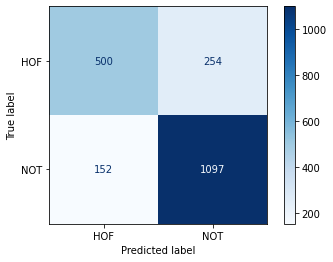

In [73]:
cm = confusion_matrix(test_y, preds, labels=[0,1,])
disp_cm = ConfusionMatrixDisplay(cm, display_labels = ['HOF', 'NOT'])
disp_cm.plot(cmap='Blues')

# Post-processing

In [68]:
### Analyze the results by language
# HOF: 0, NOT: 1
# Languages, EN: 0, DE: 1, HI: 2

test_labels1 = np.array(test_labels1)
en_actual = []
en_pred = []
hi_actual = []
hi_pred = []
de_actual = []
de_pred = []
for i in range(len(test_labels)):
    if data_test['language'][i] == 0:
        en_actual.append(test_labels1[i])
        en_pred.append(preds[i])
    if data_test['language'][i] == 1:
        de_actual.append(test_labels1[i])
        de_pred.append(preds[i])
    if data_test['language'][i] == 2:
        hi_actual.append(test_labels1[i])
        hi_pred.append(preds[i])

In [69]:
# en
print('Classification Report (English)')
print(classification_report(en_actual, en_pred))
print("Accuracy: " + str(accuracy_score(en_actual, en_pred)))

Classification Report (English)
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       423
           1       0.88      0.83      0.85       391

    accuracy                           0.86       814
   macro avg       0.87      0.86      0.86       814
weighted avg       0.87      0.86      0.86       814

Accuracy: 0.8648648648648649


In [70]:
# de
print('Classification Report (German)')
print(classification_report(de_actual, de_pred))
print("Accuracy: " + str(accuracy_score(de_actual, de_pred)))

Classification Report (German)
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       134
           1       0.90      0.88      0.89       392

    accuracy                           0.83       526
   macro avg       0.78      0.79      0.78       526
weighted avg       0.84      0.83      0.83       526

Accuracy: 0.8326996197718631


In [71]:
# hi
print('Classification Report (Hindi)')
print(classification_report(hi_actual, hi_pred))
print("Accuracy: " + str(accuracy_score(hi_actual, hi_pred)))

Classification Report (Hindi)
              precision    recall  f1-score   support

           0       0.41      0.13      0.19       197
           1       0.71      0.92      0.81       466

    accuracy                           0.69       663
   macro avg       0.56      0.52      0.50       663
weighted avg       0.62      0.69      0.62       663

Accuracy: 0.6862745098039216
